# Import packages, data and define useful functions

In [57]:
# Import all important packages and set parameters
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [58]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [59]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cpu


# Create neccessary datasets

In [60]:
# Dictionary to save important information
class dictionary(dict): 
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

In [61]:
# Instantiate params dictionary
settings = dictionary()

# Define coupling layer and normalizing flow

In [62]:
# Define coupling layer (affine coupling type)
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None):
        """
        Initializes the coupling layer.

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the hidden layers of the neural networks involved in the transformations.
        """
        # Initialize object
        super().__init__()

        # Assign variables to coupling layer input
        self.D, self.d, self.m, self.h = context_size, input_size, int(input_size/2), hidden_size

        # Decide on size of neural network input
        if context_size is not None:
            self.net_in = self.m + self.D
        else:
            self.net_in = self.m

        # Define neural network implementing the shift parameter mu of an affine function: f(x) = sig*x + mu
        self.sig_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

        # Define neural network implementing the scale parameter sigma of an affine function: f(x) = sig*x + mu
        self.mu_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

    def forward(self, x, context=None, flip=False, inverse=False):
        """
        Defines the forward and inverse direction of the coupling layer.

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Split input into two parts
        x1, x2 = torch.split(x, [self.m, self.d - self.m], dim=1)

        # Flip the two parts, if flip is True
        if flip:
            x1, x2 = torch.split(x, [self.d - self.m, self.m], dim=1)
            x2, x1 = x1, x2

        # If there is context, concatenate it with one part of the input to feed to the neural networks
        if context is not None:
            xy = torch.cat([x1, context], dim=-1)
        else:
            xy = x1

        # Instantiate and calculate neural networks for the scale and shift parameters sig and mu
        mu = self.mu_net(xy)
        sig = self.sig_net(xy)

        # Calculate forward transformation, if inverse=False
        if not inverse:
            z1, z2 = x1, mu + x2 * torch.exp(sig)

        # Calculate inverse transformation, if inverse=True
        else:
            z1, z2 = x1, (x2 - mu) * torch.exp(-sig)

        # Again flip the data, if flip is True
        if flip:
            z2, z1 = z1, z2 

        # Concatenate unprocessed and processed input to an output tensor
        z = torch.cat([z1, z2], dim=-1)

        # Calculate log-likelihood
        pz = MultivariateNormal(torch.zeros(x.shape[1]), torch.eye(x.shape[1]))
        log_pz = pz.log_prob(z)
 
        # Calculate determinant of log-likelihood
        log_det_J = sig.sum(-1)

        # Return output tensor, log-likelihood and determinant of log-likelihood
        return z, log_pz, log_det_J

In [63]:
# Define normalizing flow (RNVP type)
class NormalizingFlow(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, context_size=None):
        """
        Initializes the normalizing flow architecture

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the context, on which the input data is conditioned.
        num_layers: Integer defining the total coupling layer number of the normalizing flow.
        context_size: Size (dimension) of the context, on which the input is conditioned.
        """
        # Initialized object
        super().__init__()

        # Create a list of coupling layers with specified characteristics
        self.bijectors = nn.ModuleList([
            CouplingLayer(input_size, hidden_size, context_size) for _ in range(num_layers)
        ])

        # Create a list of alternating flip values for all coupling layers of the transformation
        self.flips = [True if i%2 else False for i in range(num_layers)]
        
    def forward(self, x, context=None, inverse=False):
        """
        Defines the forward and inverse direction of the normalizing flow

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Define empty list to store log-likelihoods and determinants of log-likelihoods
        lg_pz = []
        lg_det_J = []

        # Calculate resulting log-likelihoods and determinants thereof in forward direction
        if not inverse:
            for biijector, f in zip(self.bijectors, self.flips):
                x, lpz, ldj = biijector(x, context=context, inverse=False, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)

        # Calculate resulting log-likelihoods and determinants thereof in inverse direction
        else:
            for biijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
                x, lpz, ldj = biijector(x, context=context, inverse=True, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)
                
        # Return processed input, the total log-likelihood and the determinant of the total log-likelihood
        return x, sum(lg_pz), sum(lg_det_J)

# Define loss function

In [64]:
# Define loss function
def loss_function(model, input, context=None):
    """
    Calculates the loss for training a normalizing flow.

    model: Normalizing flow model.
    x: Input, which is to be transformed to a base distribution (standard normal distribution).
    context: Context, on which the input data is conditioned.
    """
    # Calculate processed input (output), total log-likelihood and determinant of total log-likelihood
    z, log_pz, log_det_J = model(input, context=context, inverse=False)

    # Calculate and return loss as given by the change of variable theorem of probability theory
    loss = -torch.mean(log_pz + log_det_J)
    return loss

# Instantiate settings

In [65]:
# Instantiate new dictionary
settings = dictionary()

# Import data, define dataloaders and instantiate normalizing flow

In [66]:
# Import moon data (2-dimensional dataset)
settings.train_samples = 100000
noisy_moons = datasets.make_moons(n_samples=settings.train_samples, noise=0.05)
X, _ = noisy_moons # X: 2-d points, _: Labels (belonging to moon 1 or 2)

# Make train and test splits
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [67]:
# Set batch size of datasets
settings.batch_size = 512

# Define datasets and dataloaders for training
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
dataset_train = torch.utils.data.TensorDataset(X_train)
dataset_test = torch.utils.data.TensorDataset(X_test)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [68]:
# Settings for model
settings.input_size = X.shape[1]
settings.hidden_size = 512
settings.num_layers = 10

# Instantiate the normalizing flow
normalizing_flow_moons = NormalizingFlow(settings.input_size, settings.hidden_size, settings.num_layers)

In [69]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 30

# Define optimizer and scheduler
optimizer = torch.optim.Adam(normalizing_flow_moons.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

# Train the flow

In [70]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x in dataloader_train:
        normalizing_flow_moons.train()
        optimizer.zero_grad()
        loss = loss_function(normalizing_flow_moons, batch_x[0])
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x in dataloader_test:
        normalizing_flow_moons.eval()
        loss = loss_function(normalizing_flow_moons, batch_x[0])
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 2 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 2/30 train loss: 0.0373
Epoch 2/30 test loss: 0.0375
Epoch 4/30 train loss: 0.0369
Epoch 4/30 test loss: 0.0373
Epoch 6/30 train loss: 0.0364
Epoch 6/30 test loss: 0.0367
Epoch 8/30 train loss: 0.0357
Epoch 8/30 test loss: 0.0363
Epoch 10/30 train loss: 0.0355
Epoch 10/30 test loss: 0.0361
Epoch 12/30 train loss: 0.0354
Epoch 12/30 test loss: 0.0361
Epoch 14/30 train loss: 0.0353
Epoch 14/30 test loss: 0.0360
Epoch 16/30 train loss: 0.0353
Epoch 16/30 test loss: 0.0360
Epoch 18/30 train loss: 0.0353
Epoch 18/30 test loss: 0.0359
Epoch 20/30 train loss: 0.0352
Epoch 20/30 test loss: 0.0360
Epoch 22/30 train loss: 0.0352
Epoch 22/30 test loss: 0.0359
Epoch 24/30 train loss: 0.0352
Epoch 24/30 test loss: 0.0359
Epoch 26/30 train loss: 0.0352
Epoch 26/30 test loss: 0.0359
Epoch 28/30 train loss: 0.0352
Epoch 28/30 test loss: 0.0359
Epoch 30/30 train loss: 0.0352
Epoch 30/30 test loss: 0.0359


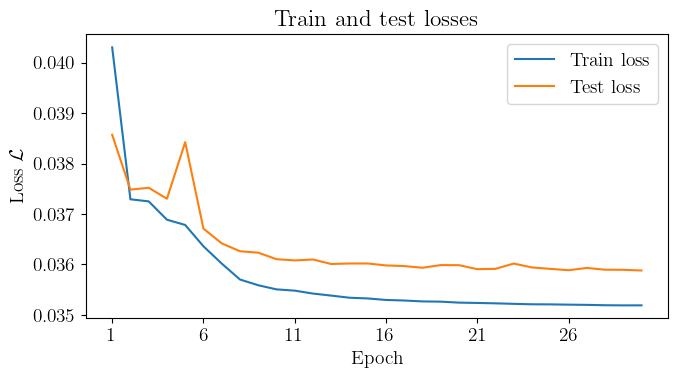

In [71]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/int(settings.num_epochs/5))
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-moons-example-loss.pdf')

# Test the flow

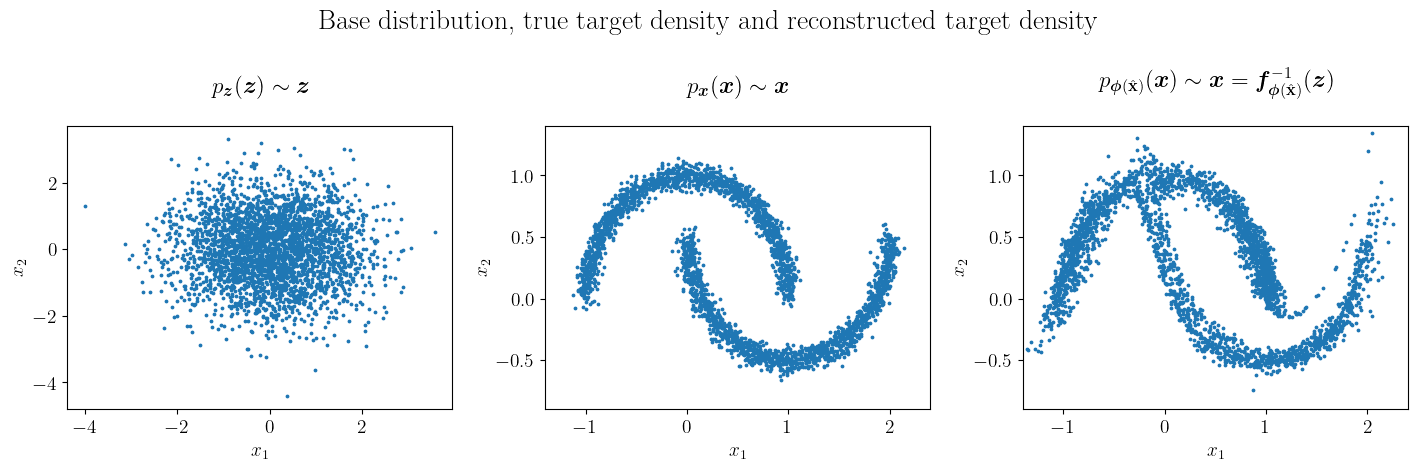

In [72]:
# Generate test data
baseu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(baseu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,)) # Standard normal distribution, z ~ p_z(z)
X_t, _ = datasets.make_moons(n_samples=3000, noise=0.05) # True target distribution, x ~ p_x(x)

# Propagate it through the inverse normalizing flow
rec_X, _, _ = normalizing_flow_moons(Z, inverse=True)
rec_X = rec_X.detach().numpy() # Reconstructed target distribution, x ~ f^{-1}(z)
rec_X_filtered = filter_outliers(rec_X, iqr_multiplier=1.3)

# Set scatter plot point size
ps = int(3)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
plt.suptitle('Base distribution, true target density and reconstructed target density', fontsize=20)
axes[0].scatter(Z[:, 0], Z[:, 1], s=ps)
axes[0].set_title('$p_{\\bm{z}}(\\bm{z}) \\sim \\bm{z}$\n')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
#axes[0].set_aspect('equal')
axes[1].scatter(X_t[:, 0], X_t[:, 1], s=ps)
axes[1].set_title('$p_{\\bm{x}}(\\bm{x}) \\sim \\bm{x}$\n')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_xlim(-1.4, 2.4)
axes[1].set_ylim(-0.9, 1.4)
#axes[1].set_aspect('equal')
axes[2].scatter(rec_X[:, 0], rec_X[:, 1], s=ps)
axes[2].set_title('$p_{\\bm{\phi}(\\hat{\\mathbf{x}})}(\\bm{x}) \\sim \\bm{x} = \\bm{f}^{-1}_{\\bm{\phi}(\\hat{\\mathbf{x}})}(\\bm{z})$\n')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_xlim(-1.4, 2.4)
axes[2].set_ylim(-0.9, 1.4)
#axes[2].set_aspect('equal')
plt.tight_layout()
plt.savefig('nf-moons-example-plots.pdf')

In [73]:
# Calculate weights for plotting
weights_true = np.ones_like(rec_X_filtered[:,0])/len(rec_X_filtered[:,0])
weights_reconstructed = np.ones_like(X_t[:,0])/len(X_t[:,0])

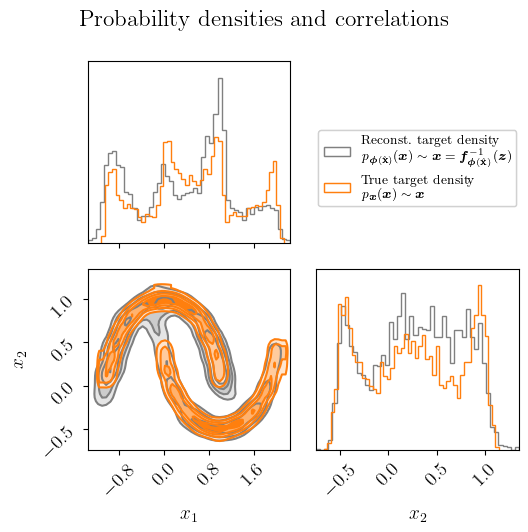

In [74]:
# Make corner plot
figure = corner.corner(rec_X_filtered, labels=['$x_1$', '$x_2$'], show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.5, weights=weights_true)
_ = corner.corner(X_t, labels=['$x_1$', '$x_2$'], show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.5, weights=weights_reconstructed, fig=figure)
plt.suptitle('Probability densities and correlations')
legend = plt.legend(['Reconst. target density\n$p_{\\bm{\phi}(\\hat{\\mathbf{x}})}(\\bm{x}) \\sim \\bm{x} = \\bm{f}^{-1}_{\\bm{\phi}(\\hat{\\mathbf{x}})}(\\bm{z})$', 'True target density\n$p_{\\bm{x}}(\\bm{x}) \\sim \\bm{x}$'], loc='upper right', bbox_to_anchor=(1.02, 1.80), handlelength=2.0, fontsize=9.5)
plt.gca().add_artist(legend)
plt.tight_layout()
plt.savefig('nf-moons-example-corner.pdf')
plt.show()

In [75]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

train_samples  :  100000
batch_size  :  512
input_size  :  2
hidden_size  :  512
num_layers  :  10
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  30
